# Target Identification Tests
## Introduction

Target identification is a very important part of an spectrum extraction since is the starting point. In this jupyter notebook I will explore several aspects of the target identification as well as different conditions.



First we load some packages

In [105]:
from ccdproc import CCDData
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import numpy as np
from scipy import signal


Now we load a sample image. Displayed below.

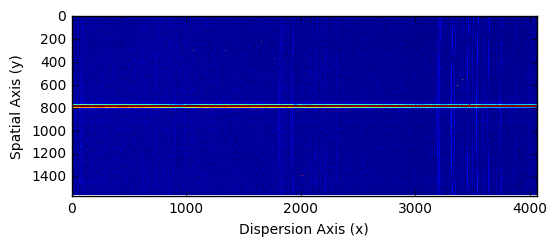

In [106]:

sample_file  = '/data/simon/data/soar/work/20161114_eng_3/RED4/cfzsto_0216_EG21_1200M5_GG455.fits' #cfzsto_0199_EG21_400M2_GG455.fits'
ccd = CCDData.read(sample_file)

plt.imshow(ccd.data, clim=(0, 350))
plt.xlabel('Dispersion Axis (x)')
plt.ylabel('Spatial Axis (y)')
plt.show()

## Identify the target.

For Goodman, the inclination of the list with respect to the detector row are very slight, so we can safely do a median calculation.

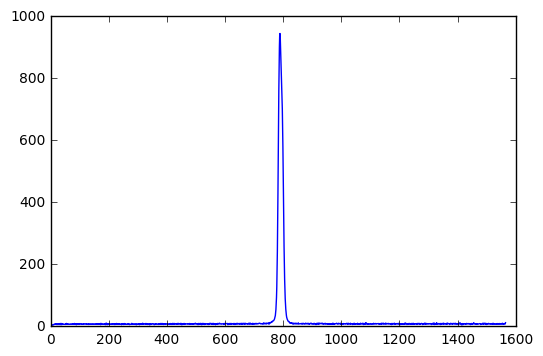

1566


In [107]:
sample = np.median(ccd.data, axis=1)

plt.plot(sample)
plt.show()
print(sample.size)

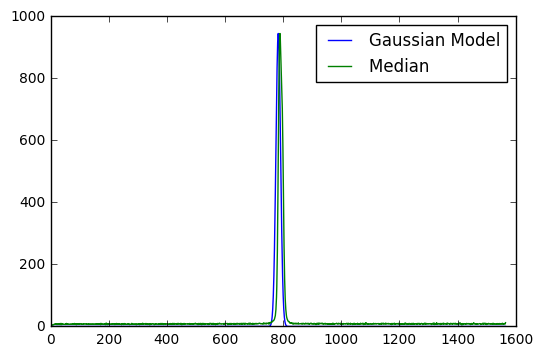

In [108]:
gauss_model = models.Gaussian1D(amplitude=sample.max(), mean=int(sample.size/2.), stddev=8).rename('Gaussian')

gauss_data = gauss_model(range(sample.size))

profile_x_axis = range(sample.size)

plt.plot(profile_x_axis, gauss_data, label='Gaussian Model')
plt.plot(sample, label='Median ')
plt.legend(loc='best')
plt.show()
# print(gauss_model)

Until now we assumed that the spectrum was located at the middle of the region but it is just a starting point. According to the paper of [Marsh, 1989](http://adsabs.harvard.edu/abs/1989PASP..101.1032M) the _right_ procedure is to do cross correlation of a gaussian to the data.

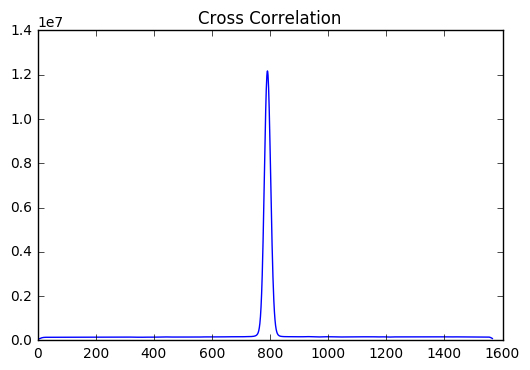

791


In [109]:
cross_corr = signal.correlate(sample, gauss_data, mode='same')
peaks = np.argmax(cross_corr)
gauss_model.mean.value = peaks
plt.title('Cross Correlation')
plt.plot(cross_corr)
plt.show()

print(peaks)

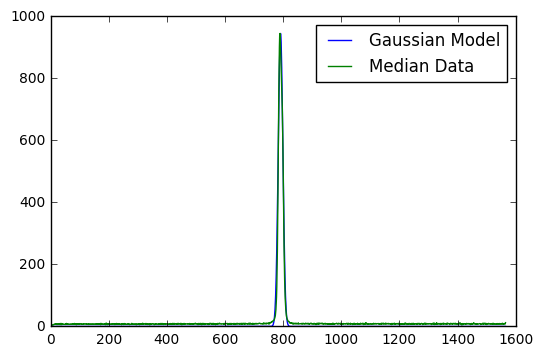

In [110]:
plt.plot(profile_x_axis, gauss_model(profile_x_axis), color='b', label='Gaussian Model')
plt.plot(sample, color='g', label='Median Data')
plt.legend(loc='best')
plt.show()

It seems clear it works very well, but let's see what happens when we have two targets in the slit.

## Double Target


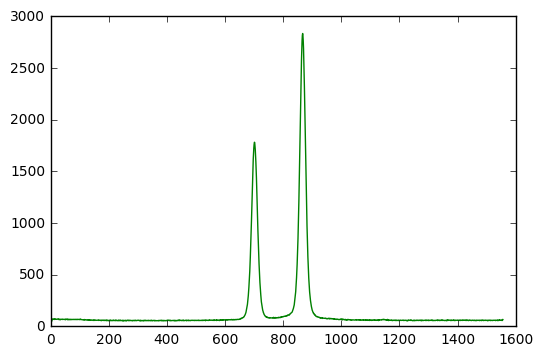

In [111]:
image = '/data/simon/data/soar/work/GOO_BLU_SPE_2017-05-09/RED/cfzsto_1086_HD104237_400M2_GG455.fits'
ccd = CCDData.read(image)

sample = np.median(ccd.data, axis=1)
plt.plot(sample, color='g')
plt.show()

Let's redefine the gaussian model.

[706 872]


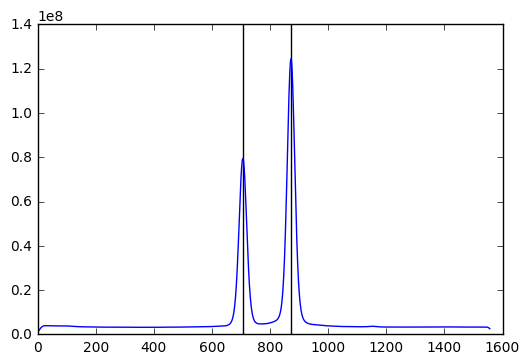

In [112]:
gauss_model = models.Gaussian1D(amplitude=sample.max(), mean=int(sample.size/2.), stddev=8).rename('Gaussian')

cross_correlation = signal.correlate(sample, gauss_model(profile_x_axis), mode='same')

filtered_data = np.where(np.abs(cross_correlation > cross_correlation.min() + 0.03 * cross_correlation.max()),
                         cross_correlation,
                         None)

peaks = signal.argrelmax(filtered_data, axis=0, order=8)[0]
print(peaks)
for peak in peaks:
    plt.axvline(peak, color='k')
plt.plot(cross_correlation)
plt.show()

Well, it works but I don't see the point of using a cross correlation with a Gaussian.

Now that I know I can detect two targets I will see how a does a double gaussian works.


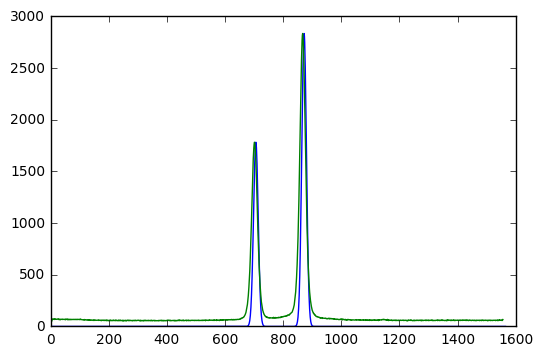

In [113]:
gaussian_1 = models.Gaussian1D(amplitude=np.max(sample[peaks[0] -10:peaks[0] + 10]), mean=peaks[0], stddev=8).rename('Gaussian_1')
gaussian_2 = models.Gaussian1D(amplitude=np.max(sample[peaks[1] -10:peaks[1] + 10]), mean=peaks[1], stddev=8).rename('Gaussian_2')
double_gaussian = gaussian_1 + gaussian_2

plt.plot(double_gaussian(profile_x_axis))
plt.plot(sample)
plt.show()

The two-gaussian model looks very similar to the data but it's not fitted yet. 

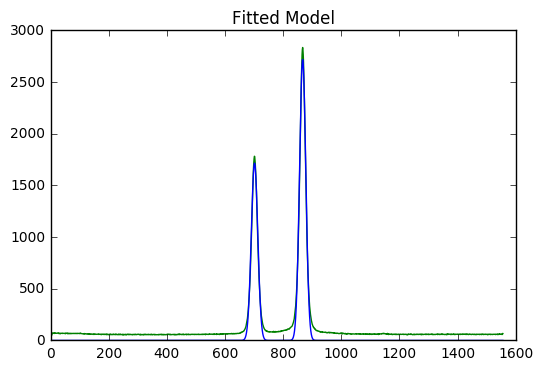

Model: CompoundModel2
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1782.551025390625, mean=706.0, stddev=8.0, name='Gaussian_1')>

    [1]: <Gaussian1D(amplitude=2834.96142578125, mean=872.0, stddev=8.0, name='Gaussian_2')>
Parameters:
     amplitude_0      mean_0       stddev_0   ...     mean_1       stddev_1  
    ------------- ------------- ------------- ... ------------- -------------
    1716.18372238 701.469599672 11.0931635115 ... 867.041828832 10.7775773487


In [114]:
# Initialize the model fitter
fit_gaussian = fitting.LevMarLSQFitter()

two_gaussian_fit = fit_gaussian(double_gaussian, range(sample.size), sample)

plt.title('Fitted Model')
plt.plot(sample, color='g')
plt.plot(two_gaussian_fit(range(sample.size)), color='b')
plt.show()
print(two_gaussian_fit)

I will try the _Enforce Positivity_ and _Normalization_ steps for the data and model.

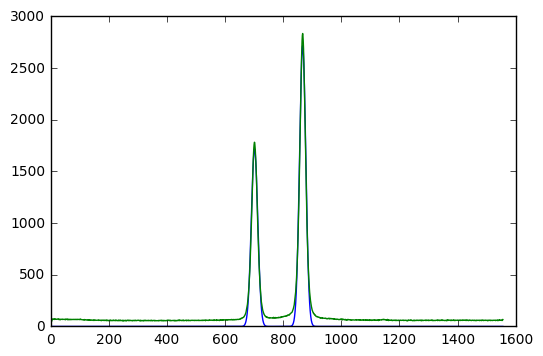

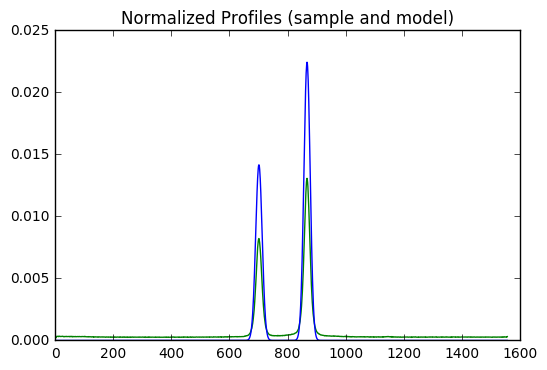

Model Sum: 1.000
Sample Sum: 1.000


In [115]:
pos_model = np.array([np.max(x, 0) for x in two_gaussian_fit(range(sample.size))])
pos_sample = np.array([np.max(x, 0) for x in sample])

plt.plot(pos_model, color='b')
plt.plot(pos_sample, color='g')
plt.show()

norm_model = np.array([x / pos_model.sum() for x in pos_model])
norm_sample = np.array([x / pos_sample.sum() for x in pos_sample])

plt.title('Normalized Profiles (sample and model)')
plt.plot(norm_sample, color='g')
plt.plot(norm_model, color='b')
plt.show()

print('Model Sum: {:.3f}'.format(norm_model.sum()))
print('Sample Sum: {:.3f}'.format(norm_sample.sum()))


### Single Gaussian Cross Correlation

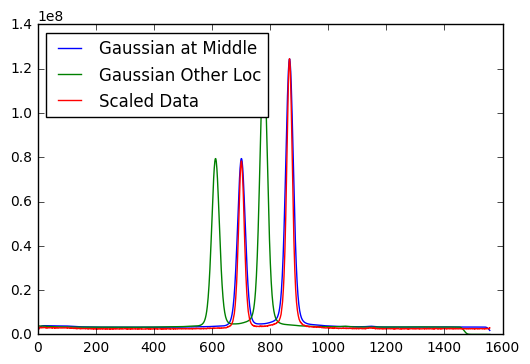

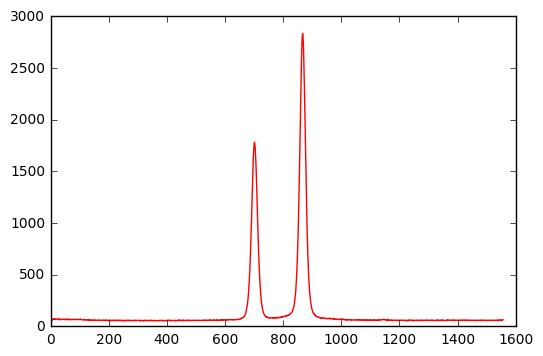

In [116]:
single_gaussian = models.Gaussian1D(amplitude=sample.max(), mean=sample.size // 2, stddev=8)
single_gaussian_2 = models.Gaussian1D(amplitude=sample.max(), mean=sample.argmax(), stddev=8)

ccorrelate = signal.correlate(sample, single_gaussian(range(sample.size)), mode='same')
ccorrelate_2 = signal.correlate(sample, single_gaussian_2(range(sample.size)), mode='same')
plt.plot(ccorrelate, label='Gaussian at Middle')
plt.plot(ccorrelate_2, label='Gaussian Other Loc')
plt.plot(sample * ccorrelate.max() / sample.max(), color='r', label='Scaled Data')
plt.legend(loc='best')
plt.show()

plt.plot(sample, color='r', label='data')
plt.show()

## Low Signal To Noise Target



(72.8899, 914)


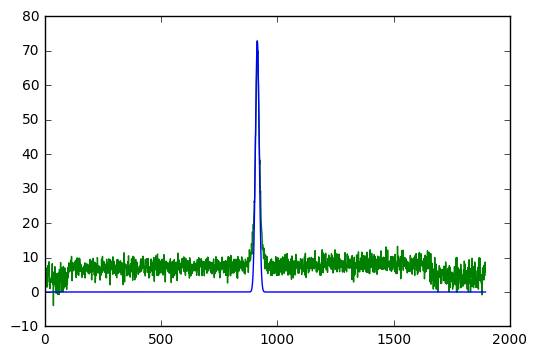

In [117]:
low_sn_image = '/data/simon/data/soar/work/GOO_BLU_SPE_2017-05-09/RED/cfzto_1051_Hen-3-729_600BlueBlue.fits'

ccd = CCDData.read(low_sn_image)
msample = np.nan_to_num(np.median(ccd.data, axis=1))

print(msample.max(), msample.argmax())
gauss_model = models.Gaussian1D(amplitude=msample.max(), mean=msample.argmax(), stddev=8.)

plt.plot(msample, color='g')
plt.plot(gauss_model(range(msample.size)), color='b')
plt.show()

Just for testing I will do the cross correlation of this.


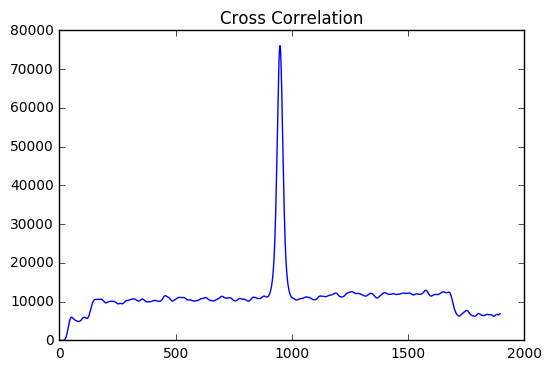

In [118]:
cross_correlation = signal.correlate(msample, gauss_model(range(msample.size)), mode='same')

plt.title('Cross Correlation')
plt.plot(cross_correlation)
plt.show()

Well, it looks like in this case the cross correlation seems to help to improve the  signal to noise of the profile.

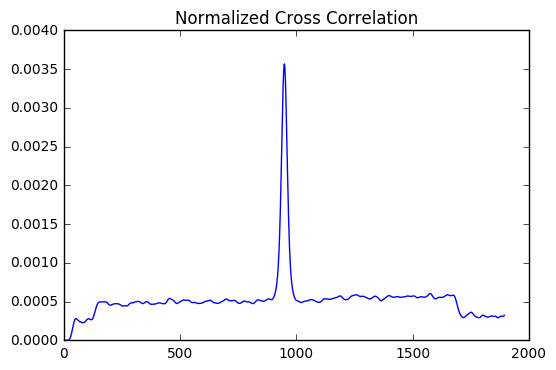

In [119]:
norm_profile = np.array([x / cross_correlation.sum() for x in cross_correlation])

plt.title('Normalized Cross Correlation')
plt.plot(norm_profile)
plt.show()

## Multiple Targets with Low Signal To Noise Ratio

This is a problematic case, where the background is not flat and the signal to noise is low. Also the slit moved from flat to object so there is a large drop of signal towards the edge. I don't think these slit movements are common now,specially with the introduction of `GACAM`

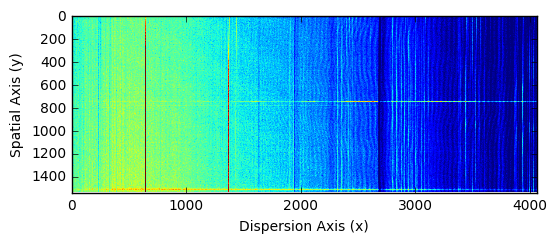

In [120]:
faint_file = '/user/simon/data/soar/work/2015-01-05/RED/cfzsto_0094.cvso727_400M2_GG455.fits'
# faint_file = '/user/simon/data/soar/work/2015-01-05/RED/cfzsto_0104.cvso36_400M2_GG455.fits'

ccd = CCDData.read(faint_file)

plt.imshow(ccd.data, clim=(30, 250))
plt.xlabel('Dispersion Axis (x)')
plt.ylabel('Spatial Axis (y)')
plt.show()

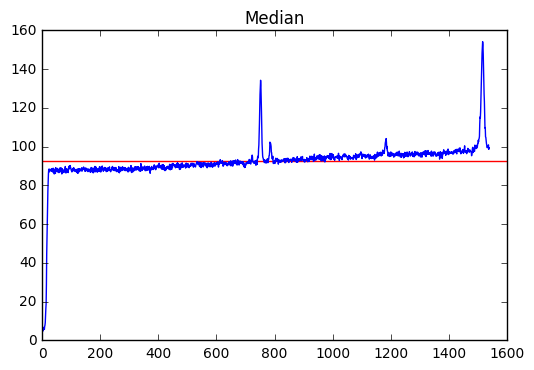

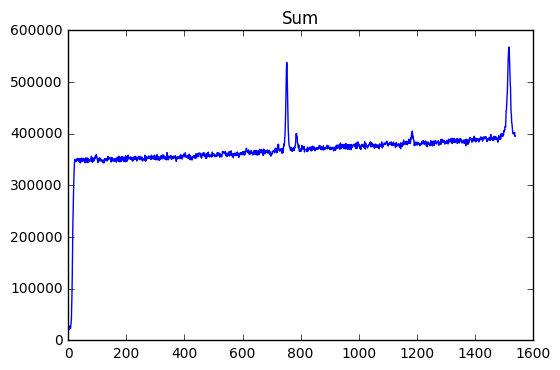

In [121]:
median_profile = np.median(ccd.data, axis=1)
sum_profile = np.sum(ccd.data, axis=1)
median_median = np.median(median_profile)

plt.title('Median')
plt.axhline(median_median, color='r')

plt.plot(median_profile)
plt.show()


plt.title('Sum')
plt.plot(sum_profile)
plt.show()

## Fitting Background

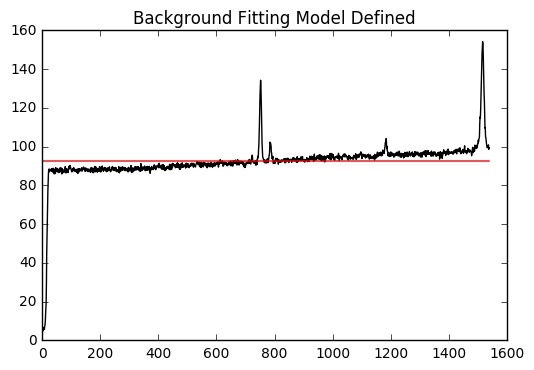

In [122]:
linear_model = models.Linear1D(slope=0, intercept=np.median(median_profile))


plt.title('Background Fitting Model Defined')
plt.plot(median_profile, color='k')
plt.plot(linear_model(range(ccd.data.shape[0])), color='r')
plt.show()

Before doing the fitting we will do a sigma clipping in order to remove any feature.

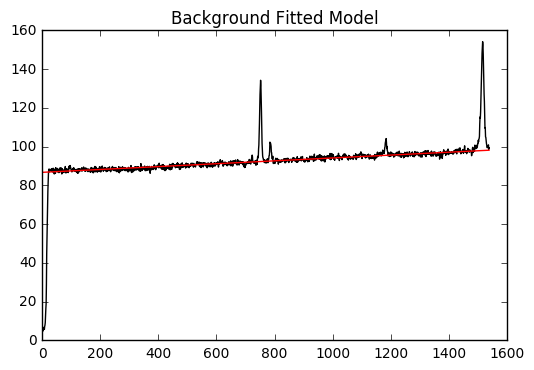

In [123]:
linear_fitter = fitting.LinearLSQFitter()

clipped_profile = sigma_clip(median_profile, sigma=2, iters=5)

# the fitters do not support masked arrays so we need to rebuild them.
new_profile = clipped_profile[~clipped_profile.mask]
new_x_axis = np.argwhere(clipped_profile != clipped_profile.mask).ravel()

fitted_background = linear_fitter(linear_model, new_x_axis, new_profile)


plt.title('Background Fitted Model')
plt.plot(median_profile, color='k')
plt.plot(fitted_background(range(ccd.data.shape[0])), color='r')

plt.show()

## Removing Background

Remove the background and set negative values to zero

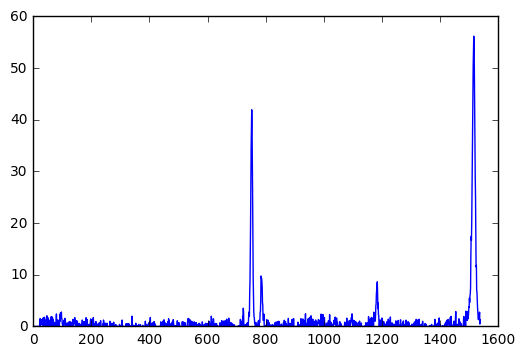

In [124]:
background_array = fitted_background(range(len(median_profile)))

background_subtracted = median_profile - background_array

background_subtracted[background_subtracted < 0] = 0
final_profile = background_subtracted.copy()

plt.plot(background_subtracted)
# plt.plot(final_profile, color='r')
# plt.plot(median_profile)
# plt.plot(background_array)
plt.show()

## Identify targets
Now that the profile is flat it should be easier to identify targets.

[ 56.18025005  41.93690507   9.77394183   8.63842874   3.52364834
   2.97221739   2.88899002   2.79042741   2.4421582    2.43970467
   2.41923749   2.3839651    2.26328629]
2.24721000186


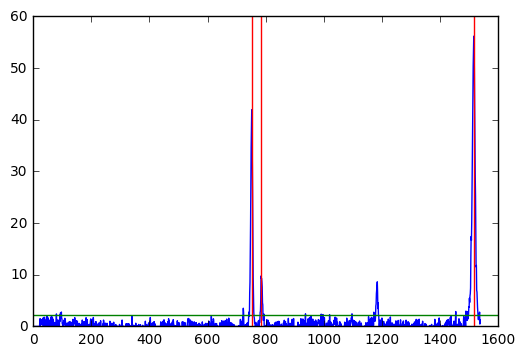

1.11.1


In [132]:
filtered_profile = np.where(np.abs(final_profile > final_profile.min() + 0.04 * final_profile.max()), final_profile, None)

_upper_limit = final_profile.min() + 0.04 * final_profile.max()
# print(_upper_limit)
# print(np.median(final_profile))

peaks = signal.argrelmax(filtered_profile, axis=0, order=8)[0]
values = [final_profile[i] for i in peaks]
# print(peaks)
sorted_values = np.sort(values)[::-1]
print(sorted_values)
print(_upper_limit)
n_top_values = sorted_values[:3]
# print(n_top_values)

selected_peaks = []
for val in n_top_values:
    index = np.where(values == val)[0]
#     print(index[0])
    selected_peaks.append(peaks[index[0]])

plt.plot(final_profile)
plt.axhline(_upper_limit, color='g')
for peak in selected_peaks:
    plt.axvline(peak, color='r')
plt.show()
print(np.__version__)

Before attempting to trace the target, which is a problem for targets this faint, I will take a guess using a linear model.

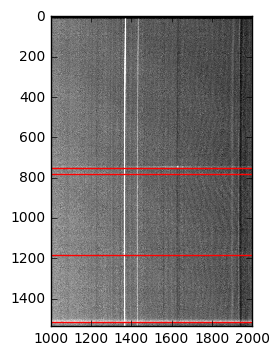

In [126]:
plt.imshow(ccd.data, clim=(50, 200), cmap='gray')
for peak in selected_peaks:
    plt.axhline(peak, color='r')
plt.xlim((1000,2000))
plt.show()

Guessing the trace is not the right way to go, I need to find a better solution for this.

I'm thinking on using a combination of 
- Initial Trace guess (constant)
- Define sampling steps along the guessed trace
- Grab 2 FWHM and find peaks
- Then do sigma_clip to the peak values and do fit with what is left. 
- If too few are left use guessed value.

### Initial Trace Guess

In [128]:
trace_init = models.Polynomial1D(degree=2)
